In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import scipy
from scipy.stats.stats import pearsonr
import scipy.stats as stats
from tqdm import tqdm_notebook as tqdm

In [21]:
PATH = r"D:\INR\variations\MEPHI10-18"

### Чтение данных за годы с установки и запись их в файл: давление и темп счета нейтронов (2012 - 2018)

Измерения с детекторов снимаются раз в 5 минут. Соответсвенно можно усреднять показания по 30 минут, 1 и 2 часам. 

In [22]:
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity']
Itog = pd.DataFrame(columns = new_names)
statistic = pd.DataFrame(columns = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4'], index = ['Pressure', 'T, C', 'Humidity'])

#Чтение данных
for I in tqdm(range(12,19,1)):
    directory = PATH+r"\20"+str(I)
    files = os.listdir(directory) 
    for i in (files):
        s=str(i)
        if (len(s)== 10):
            data1 = pd.read_csv(PATH+r"\20%s\%s" %( str(I),i), names = new_names, 
                                delim_whitespace = True, usecols = [1,2,3,4,9,10,11])
            data1['D'] = int(s[5:7:1])
            data1['M'] = int(s[2:4:1])
            data1['Y'] = int('20'+s[8:])
            
            for d in range(0,data1.shape[0],1):
                data1.loc[d, 'H'] = (d//12)
                
            for d in range(0,24,1):
                for j in range(1,5,1):
                    data1.loc[data1['H'] == d, 'Neutr%s' %j] = data1[data1['H'] == d]['Neutr%s'%j].mean()
                                        
            data1.drop_duplicates(subset = 'H', keep = 'first', inplace = True)   
            data1.dropna(inplace = True)
            Itog = pd.merge(Itog, data1, how = 'outer')
    Itog = Itog[Itog['Neutr1']>0][Itog['Neutr2']>0][Itog['Neutr3']>0][Itog['Neutr4']>0]

# Усреднение темпов счета нейтронов за месяц
#for l in tqdm( range (2012,2019,1) ):
#    for i in range (1,13,1):
        
#        for j in range(1,5,1):
#            if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0]>0 ) :
#                Itog.loc[(Itog['M'] == i)&(Itog['Y'] == l), 'Neutr%s' %j] = Itog[Itog['M'] == i][Itog['Y'] == l]
#['Neutr%s'%j]/Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j].mean()
        

        
        
# Усреднение темпов счета все время
Itog['Neutr1'] = Itog['Neutr1']/Itog['Neutr1'].mean()
Itog['Neutr2'] = Itog['Neutr2']/Itog['Neutr2'].mean()
Itog['Neutr3'] = Itog['Neutr3']/Itog['Neutr3'].mean()
Itog['Neutr4'] = Itog['Neutr4']/Itog['Neutr4'].mean()

Itog
#Запись данных в файл                
Itog.to_csv(PATH+"\Result60.txt", sep = ' ', header = False, index = False, mode ='w+')       

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1208: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Построение графиков для барометрического коэффициента

In [28]:
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity', 'D', 'M', 'Y', 'H']
Itog = pd.read_csv(PATH+r"\Result60.txt", names = new_names, delim_whitespace = True)
statistic = pd.DataFrame(columns = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4'], index = ['Pressure', 'T, C', 'Humidity'])
Itog = Itog[Itog['Neutr1']>0.4][Itog['Neutr2']>0.4][Itog['Neutr3']>0.4][Itog['Neutr4']>0.4]
Itog = Itog[Itog['Neutr1']<2][Itog['Neutr2']<2][Itog['Neutr3']<2][Itog['Neutr4']<2]
Itog['date'] = pd.to_datetime(Itog.apply(lambda x: str(int(x['D']))+'-'+str(int(x['M']))+'-'+str(int(x['Y'])),axis=1))

# Построение барометрического коэффициента для для каждого месяца из данных
for l in tqdm( range (2012,2019,1) ):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :
            plt.figure(figsize = (21, 21))
            for j in range(1,5,1):
                plt.subplot(2,2,j)
                plt.grid(True, linestyle='--', color='0.75')
                plt.xlabel('Давление, мм рт ст', size = '14')
                plt.ylabel('Относительный темп счета', size = '14')
                plt.title('Рассчеты для детектора с номером %d' %(j), size = '16')
                y = Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j]
                x = Itog[Itog['M'] == i][Itog['Y'] == l]['Pressure' ]
                z=np.polyfit(x,y,1)
                dis = np.linspace(x.min(),x.max(),num=100)
                plt.text(x.min(), y.min() + 0.08*y.min() , 'y = %f*x + %f' %(z[0], z[1]), size = '14')
                plt.plot(x, y, '.', label = 'Реальные значения')
                plt.plot(dis, z[0]*(dis) + z[1], 'r', label='Аппроксимация прямой', linewidth = 3)
                plt.legend(title='Обозначения:')
            plt.savefig(PATH+r"/pictures/%s/bar_coef%s.png" %(str(l),str(i))) 
            plt.close()
            


#Постороение темпа счета по времени
for i in range(1,5,1):
    plt.figure(figsize = (21, 10))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Время', size = '14')
    plt.ylabel('Относительный темп счета', size = '14')
    plt.title('Зависимость темпа счета от времени для детектора %s' %i, size = '16')
    plt.plot(Itog['date'],Itog['Neutr%s' %i],  '.')
    plt.savefig(PATH+r"/pictures/N_abs-date-det_%s.png" %i ) 
    plt.close()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarnin

### Построение барометрических коэффициентов от времени

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditione

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\INR\\variations\\MEPHI10-18pictures/PT-date-det_1.png'

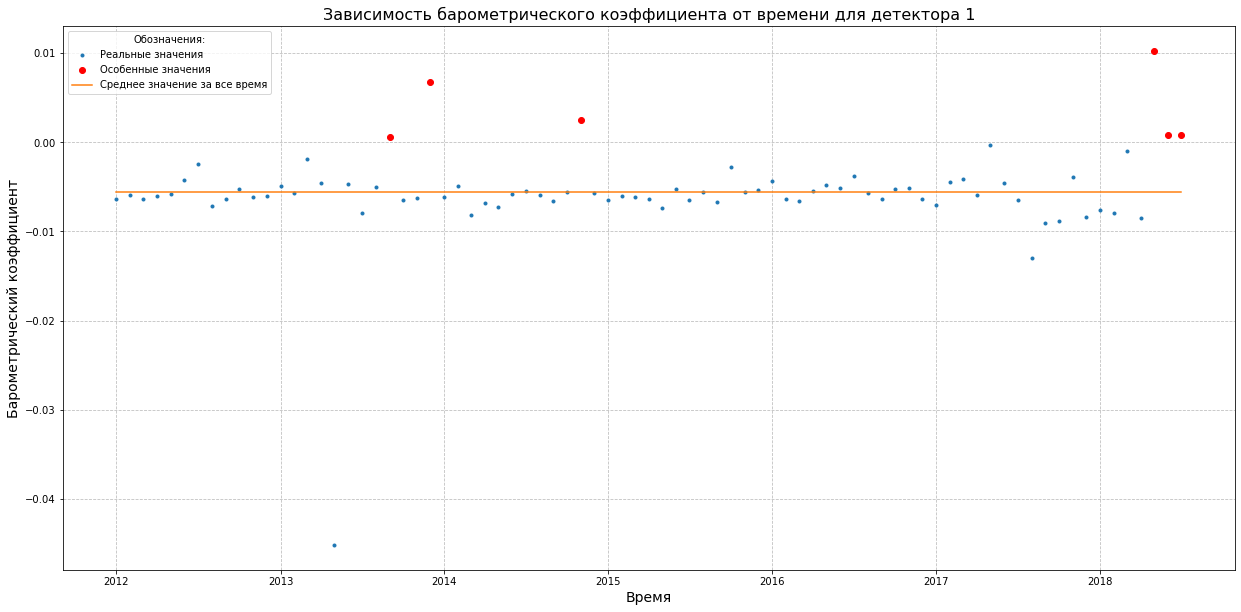

In [30]:
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity', 'D', 'M', 'Y', 'H']
Itog = pd.read_csv(PATH+r"\Result60.txt", names = new_names, delim_whitespace = True)
statistic = pd.DataFrame(columns = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4'])
Itog = Itog[Itog['Neutr1']>0.1][Itog['Neutr2']>0.1][Itog['Neutr3']>0.1][Itog['Neutr4']>0.1]
Itog['date'] = pd.to_datetime(Itog.apply(lambda x: str(int(x['D']))+'-'+str(int(x['M']))+'-'+str(int(x['Y'])),axis=1))

# Получение фрейма с барометрическими коэффициентами для каждого детектора по датам
ind = 0
for l in range (2012,2019,1):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :
            for j in range(1,5,1):
                y = Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j]
                x = Itog[Itog['M'] == i][Itog['Y'] == l]['Pressure' ]
                statistic.loc[ind, 'Neutr%s' %j] = np.polyfit(x,y,1)[0]
            statistic.loc[ind,'M'] = i
            statistic.loc[ind,'Y'] = l
            statistic.loc[ind, 'date'] = pd.to_datetime(str(i) + '-' + str(l))
            ind +=1

# Построение графиков зависимости
for i in range(1,5,1):
    plt.figure(figsize = (21, 10))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Время', size = '14')
    plt.ylabel('Барометрический коэффициент', size = '14')
    plt.title('Зависимость барометрического коэффициента от времени для детектора %s' %i, size = '16')
    plt.plot(statistic['date'],statistic['Neutr%s' %i],  '.', label = 'Реальные значения')
    plt.plot(statistic[statistic['Neutr%s' %i]>0]['date'],statistic[statistic['Neutr%s' %i]>0]['Neutr%s' %i],  'ro', label = 'Особенные значения')
    plt.plot( 
        [statistic['date'].min(),statistic['date'].max()], 
        [statistic['Neutr%s'%i].mean(),statistic['Neutr%s'%i].mean()],
        '-', label = 'Среднее значение за все время'
    )
    plt.legend(title='Обозначения:')
    plt.savefig(PATH+r"pictures/PT-date-det_%s.png" %i ) 
    plt.close()

### Построение зависимостей барометрического коэффициента от параметров

In [32]:
new_names = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4','Pressure', 'T, C', 'Humidity', 'D', 'M', 'Y', 'H']
Itog = pd.read_csv(PATH+r"\Result60.txt", names = new_names, delim_whitespace = True)
statistic = pd.DataFrame(columns = ['Neutr1', 'Neutr2', 'Neutr3', 'Neutr4'])
Itog = Itog[Itog['Neutr1']>0.1][Itog['Neutr2']>0.1][Itog['Neutr3']>0.1][Itog['Neutr4']>0.1]
Itog['date'] = pd.to_datetime(Itog.apply(lambda x: str(int(x['D']))+'-'+str(int(x['M']))+'-'+str(int(x['Y'])),axis=1))

# Получение фрейма с барометрическими коэффициентами для каждого детектора по датам
ind = 0
for l in range (2012,2019,1):
    for i in range (1,13,1):
        if ( Itog[Itog['M'] == i][Itog['Y'] == l].shape[0] > 1 ) :
            for j in range(1,5,1):
                y = Itog[Itog['M'] == i][Itog['Y'] == l]['Neutr%s'%j]
                x = Itog[Itog['M'] == i][Itog['Y'] == l]['Pressure' ]
                statistic.loc[ind, 'Neutr%s' %j] = np.polyfit(x,y,1)[0]
                statistic.loc[ind, 'T, C'] = Itog[Itog['M'] == i][Itog['Y'] == l]['T, C'].mean()
                statistic.loc[ind, 'Humidity'] = Itog[Itog['M'] == i][Itog['Y'] == l]['Humidity'].mean()
                statistic.loc[ind, 'Pressure'] = Itog[Itog['M'] == i][Itog['Y'] == l]['Pressure'].mean()
                
            statistic.loc[ind,'M'] = i
            statistic.loc[ind,'Y'] = l
            statistic.loc[ind, 'date'] = pd.to_datetime(str(i) + '-' + str(l))
            ind +=1

# Построение графиков зависимости
for i in range(1,5,1):
    plt.figure(figsize = (21, 10))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Температура', size = '14')
    plt.ylabel('Барометрический коэффициент', size = '14')
    plt.title('Зависимость барометрического коэффициента от температуры для детектора %s' %i, size = '16')
    plt.plot(statistic['T, C'],statistic['Neutr%s' %i],  '.', label = 'Реальные значения')
    plt.legend(title='Обозначения:')
    plt.savefig(PATH+r"/pictures/PT-T-det_%s.png" %i ) 
    plt.close()
    
# Построение графиков зависимости
for i in range(1,5,1):
    plt.figure(figsize = (21, 10))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Давление', size = '14')
    plt.ylabel('Барометрический коэффициент', size = '14')
    plt.title('Зависимость барометрического коэффициента от давления для детектора %s' %i, size = '16')
    plt.plot(statistic['Pressure'],statistic['Neutr%s' %i],  '.', label = 'Реальные значения')
    plt.legend(title='Обозначения:')
    plt.savefig(PATH+r"/pictures/PT-P-det_%s.png" %i ) 
    plt.close()
    
# Построение графиков зависимости
for i in range(1,5,1):
    plt.figure(figsize = (21, 10))
    plt.grid(True, linestyle='--', color='0.75')
    plt.xlabel('Влажность', size = '14')
    plt.ylabel('Барометрический коэффициент', size = '14')
    plt.title('Зависимость барометрического коэффициента от влажности для детектора %s' %i, size = '16')
    plt.plot(statistic['Humidity'],statistic['Neutr%s' %i],  '.', label = 'Реальные значения')
    plt.legend(title='Обозначения:')
    plt.savefig(PATH+r"/pictures/PT-H-det_%s.png" %i ) 
    plt.close()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFra

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.8797479725756415 0.08109900587585987 0.05266686141129769 -0.33353475303180796
0.8797479725756415 0.055855366528697326 0.08394539520587398 -0.5813330410005622
0.8797479725756415 0.1539133743387674 0.13680732520718425 -0.6143953658193556
0.8797479725756415 0.09871947740977582 0.04238879184526091 -0.39165021809823475


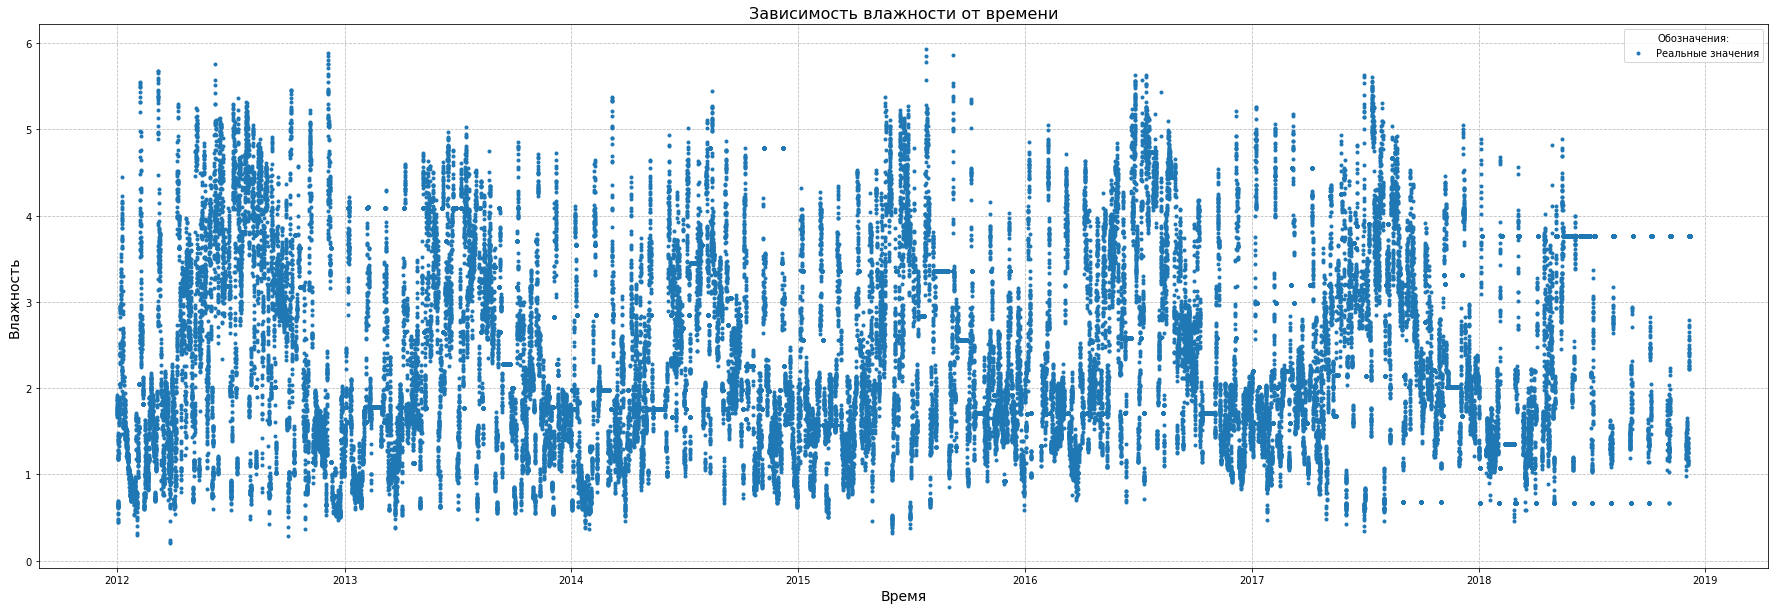

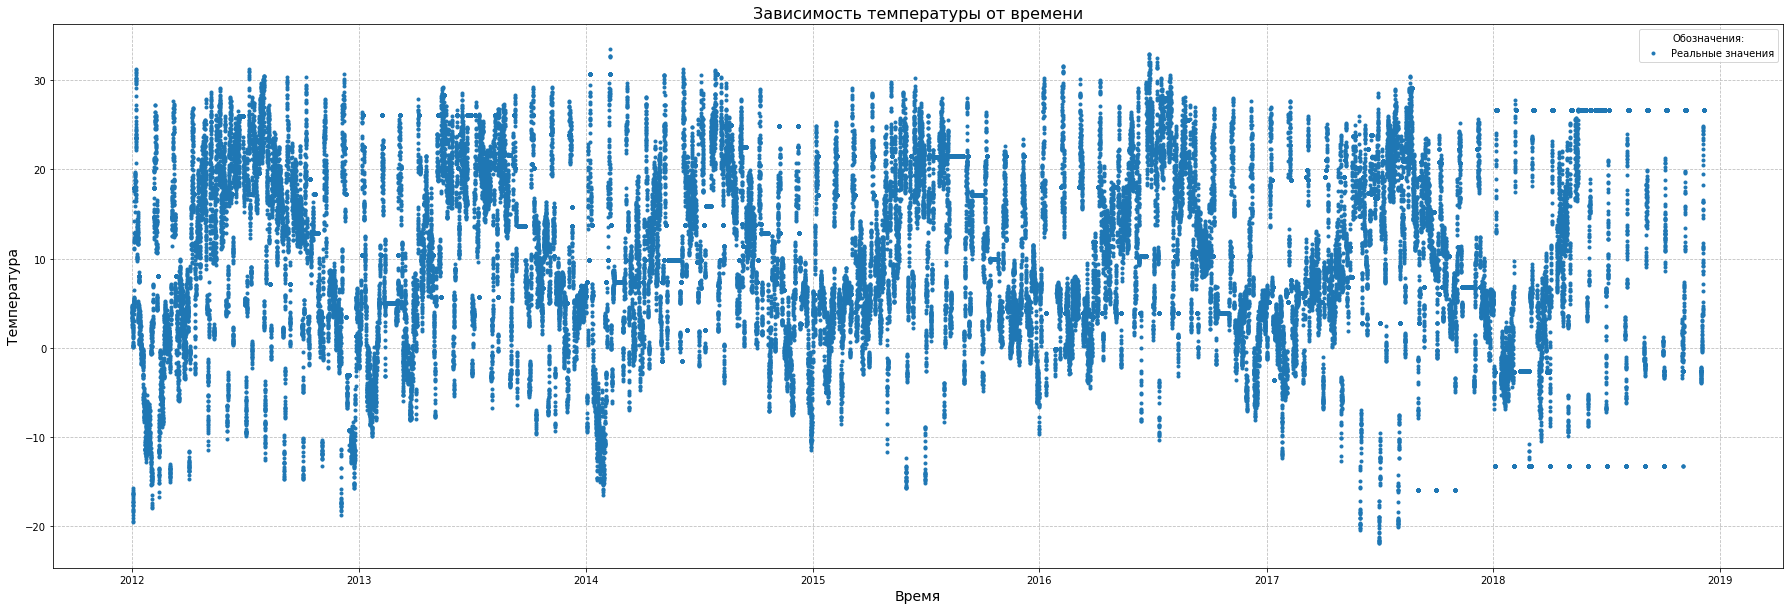

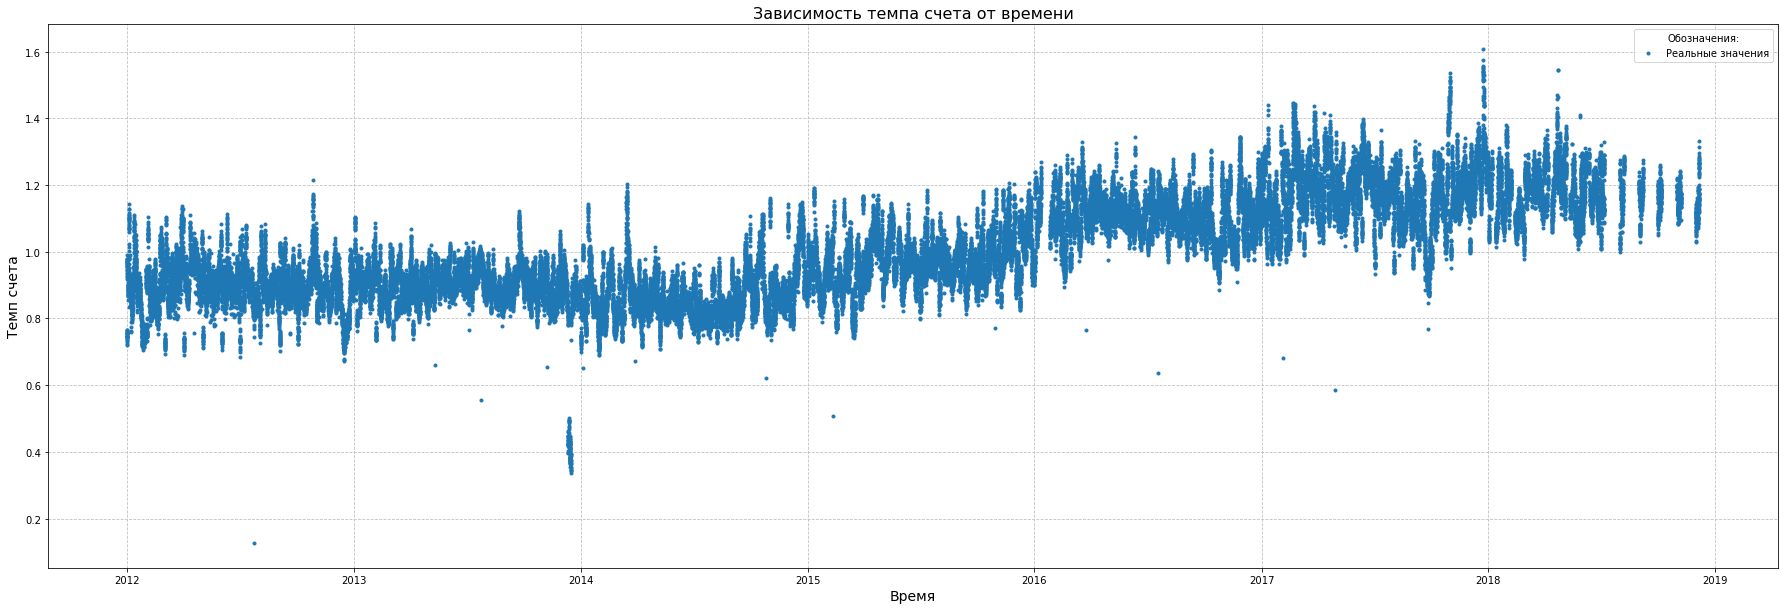

In [33]:
Itog = Itog[Itog['Neutr1']>0.1][Itog['Neutr2']>0.1][Itog['Neutr3']>0.1][Itog['Neutr4']>0.1]
Itog = Itog[Itog['Neutr1']<2][Itog['Neutr2']<2][Itog['Neutr3']<2][Itog['Neutr4']<2]

plt.figure(figsize = (31, 10))
plt.grid(True, linestyle='--', color='0.75')
plt.xlabel('Время', size = '14')
plt.ylabel('Влажность', size = '14')
plt.title('Зависимость влажности от времени', size = '16')
plt.plot(Itog['date'],  Itog['Humidity'],'.', label = 'Реальные значения')
plt.legend(title='Обозначения:')
#plt.savefig('D:/variations/MEPHI10-18/pictures/PT-H-det_%s.png' %i ) 
#plt.close()


plt.figure(figsize = (31, 10))
plt.grid(True, linestyle='--', color='0.75')
plt.xlabel('Время', size = '14')
plt.ylabel('Температура', size = '14')
plt.title('Зависимость температуры от времени', size = '16')
plt.plot(Itog['date'],  Itog['T, C'],'.', label = 'Реальные значения')
plt.legend(title='Обозначения:')


plt.figure(figsize = (31, 10))
plt.grid(True, linestyle='--', color='0.75')
plt.xlabel('Время', size = '14')
plt.ylabel('Темп счета', size = '14')
plt.title('Зависимость темпа счета от времени', size = '16')
plt.plot(Itog['date'],  Itog['Neutr4'],'.', label = 'Реальные значения')
plt.legend(title='Обозначения:')

for i in range (1, 5,1):
    qa = stats.pearsonr(Itog['T, C'], Itog['Humidity'])[0]
    
    qb = stats.pearsonr(Itog['Neutr%s'%(i)], Itog['Humidity'])[0]
    
    qc =  stats.pearsonr(Itog['Neutr%s'%(i)], Itog['T, C'])[0]
    
    qd =  stats.pearsonr(Itog['Neutr%s'%(i)], Itog['Pressure']) [0]
    print(qa, qb, qc, qd)